# Assignment "FL Main Flavors"

## 1. Preparation

### 1.1 Libraries

In [34]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# We will use networx objects to store empircial graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [35]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):
    num_stations = len(G_FMI.nodes)
    colors = np.array(['black', 'green', 'red', 'brown', 'deeppink',
                        'blue', 'olive', 'gray', 'orange', 'purple'])
    coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    # Create a plot
    fig, ax = plt.subplots()
    # Draw nodes
    for node in G_FMI.nodes:
        color = colors[G_FMI.nodes[node]['cluster']]
        ax.scatter(coords[node,1], coords[node,0], color=color, s=4, zorder=5)  # zorder ensures nodes are on top of edges
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color=color, fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    plt.show()
    
    
# The function connects each FMI station with 
# the nearest neighbours. 
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes): 
        for iter_ii in range(nrnodes): 
            if iter_i != iter_ii : 
                if A[iter_i,iter_ii]> 0 :
                    graph.add_edge(iter_i, iter_ii)
    return graph

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp" 
# returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label 
    for ind in range(nrdatapoints):
        # latitude of FMI station, normalized by 100 
        lat = float(data['Latitude'].iloc[ind])/100
        # longitude of FMI station, normalized by 100
        lon = float(data['Longitude'].iloc[ind])/100
        # temperature value of the data point 
        tmp = data['temp'].iloc[ind]
        # read the date and time of the temperature measurement 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2 Data

### 2.1 Dataset

In [36]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

data.head()

,Latitude,Longitude,Timestamp,temp,name
0,69.04277,20.85091,2023-12-31 18:00:00,-16.5,Enontekiö Kilpisjärvi Saana
1,64.11197,28.33639,2023-12-30 00:00:00,-12.4,Sotkamo Kuolaniemi
2,64.11197,28.33639,2023-12-30 15:00:00,-10.5,Sotkamo Kuolaniemi
3,70.08203,27.89650,2023-12-30 11:00:00,-25.3,Utsjoki Nuorgam
4,59.95911,19.95374,2023-12-31 03:00:00,-3.1,Lemland Nyhamn


### 2.2 Empirical graph

The empirical graph is connected: True


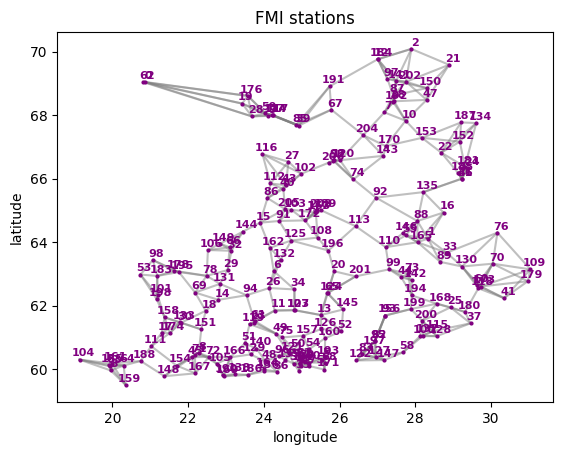

In [37]:
####################TODO####################
# TODO:
# 1. Construct the empirical graph G_FMI as a networkx.Graph() object.
# 2. Add a single node for each station.
# 3. Each node i must have the following attributes: 
#   'samplesize' - the number of measurements of the i-th weather station,
#   'name' - the name of the i-th weather station,
#   'coord' - the coordinates of the i-th weather station,
#   'X' - the feature matrix,
#   'y' - the label vector,
#   'cluster' - the index of the cluster to which node i belongs to 

# raise NotImplementedError

# G_FMI = 

# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, num_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X, y = ExtractFeatureMatrixLabelVector(station_data)
    
    # # Split the dataset into training and validation set. 
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

    localsamplesize = len(y)
    G_FMI.nodes[i]['samplesize'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]) # The coordinates of the i-th weather station,
    G_FMI.nodes[i]['X'] = X # The feature matrix at node i
    G_FMI.nodes[i]['y'] = y  # The label vector at node i
    G_FMI.nodes[i]['cluster'] = -1 # The index of the cluster to which node i belongs to
                                   # This is only a placeholder for later clustering

# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes.
numneighbors = 4
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. Model

### 3.1 Main hyperparameters

In [38]:
# Define the number of clusters and the random seed.
k = 10
seed = 4740

### 3.2 Student task #1 - K-Means with coordinates as a representation vector.

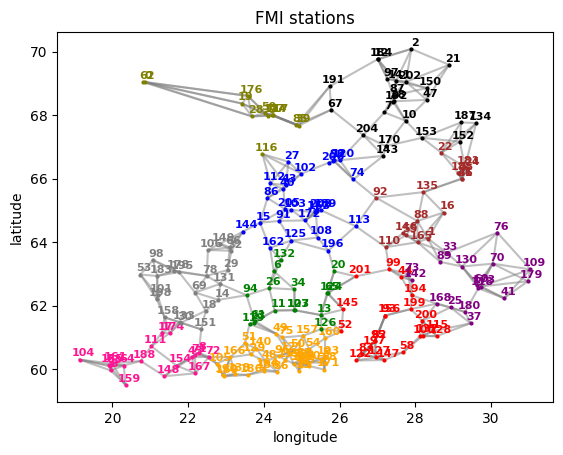

In [39]:
####################TODO####################
# TODO: 1. Create a 2-dimensional representation vector
#          with entries being the latitude and longitude 
#          of each FMI station.
#       2. Cluster the nodes of G_FMI using the Python class sklearn.cluster.KMean.
#       3. Store the cluster index in the nodes' attribute 'cluster'. 
        
# raise NotImplementedError

from sklearn.cluster import KMeans

# Extract coordinates for clustering
coords = np.array([G_FMI.nodes[i]['coord'] for i in range(num_stations)])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=seed).fit(coords)

# Assign cluster labels to nodes
for i in range(num_stations):
    G_FMI.nodes[i]['cluster'] = kmeans.labels_[i]


# Plot the clustered graph.
plotFMI(G_FMI)

In [40]:
####################TODO####################
# TODO: 1. Compute the average temperature for each cluster.
#       2. Calculate the average (over all nodes) squared 
#          error loss (see the Lecture Notes 6.7).

# raise NotImplementedError
# avg_error = 

# Step 1: Compute the average temperature for each cluster
cluster_temperatures = {cluster: [] for cluster in range(k)}  # k is the number of clusters
for i in G_FMI.nodes:
    cluster = G_FMI.nodes[i]['cluster']
    temperatures = G_FMI.nodes[i]['y']  # y contains the temperatures for the node
    avg_temp = np.mean(temperatures)
    cluster_temperatures[cluster].append(avg_temp)

cluster_average_temps = {cluster: np.mean(temps) for cluster, temps in cluster_temperatures.items()}

# Step 2: Calculate the average squared error loss
squared_errors = []
for i in G_FMI.nodes:
    cluster = G_FMI.nodes[i]['cluster']
    temperatures = G_FMI.nodes[i]['y']
    cluster_avg_temp = cluster_average_temps[cluster]
    # Compute squared error for each temperature of the node
    errors = [(temp - cluster_avg_temp) ** 2 for temp in temperatures]
    squared_errors.extend(errors)

avg_error = np.mean(squared_errors)

# Print the average error.
print(f"The average squared loss over all datapoints is {avg_error}")

The average squared loss over all datapoints is 36.419995057609505


### 3.3 Student task #2 - K-Means with GMM parameters as a representation vector.

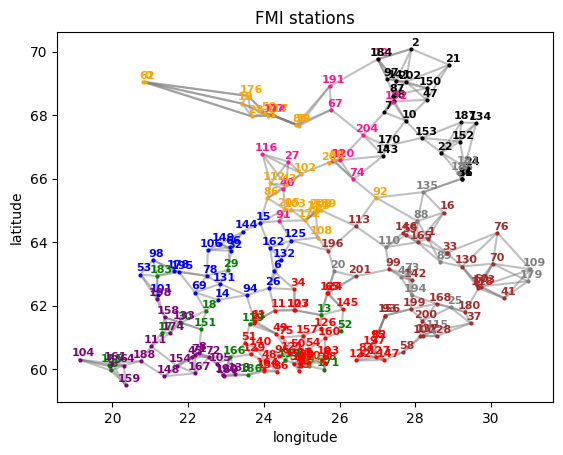

In [41]:
# Define the number components for the GMM. 
n_components = 2

####################TODO####################
# TODO: 1. Fit the GaussianMixture() model 
#          to each node in the G_FMI. Use
#          the pre-defined n_componentes and
#          random_state (seed) values.
#       2. Extract the parameters of the fitted
#          model.
#       3. Create a 2-dimensional representation vector 
#          of the shape (207, 114) with entries being the GMM parameters.
#       4. Cluster the nodes of G_FMI using the Python class sklearn.cluster.KMean.
#       5. Store the cluster labels in the nodes' attribute 'cluster'.
# HINT: GMM parameters can be extracted with 
#          .means_ - returns the matrix with
#                    entries being the mean vectors
#                    of each mixture component,
#          .covariances_ - returns the list of covariance matrices
#                          of each mixture component,
#          .weights_ - returns the weights of each mixture components.
#       Use .ravel() to flatten all parameters and .concatenate()
#       to stack them together. 
#       Therefore, the stacked parameters of each node have the shape (114, ).
#       The raveled parameters are in the following order: means, covariances, weights. 

# raise NotImplementedError

num_nodes = len(G_FMI.nodes)

# Container for the representation vectors
representation_vectors = np.zeros((num_nodes, 114))  # Adjust the size (207, 114) based on actual parameters extracted

for i in G_FMI.nodes:
    X = G_FMI.nodes[i]['X']  # Feature matrix for the node

    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=seed).fit(X)

    # Extract and flatten parameters
    means = gmm.means_.ravel()
    covariances = gmm.covariances_.ravel()
    weights = gmm.weights_.ravel()

    # Concatenate parameters to form a representation vector
    representation_vector = np.concatenate([means, covariances, weights])
    representation_vectors[i, :] = representation_vector

# Cluster the nodes using their representation vectors
kmeans = KMeans(n_clusters=k, random_state=seed)  # Adjust the number of clusters if needed
clusters = kmeans.fit_predict(representation_vectors)

# Store the cluster labels in the nodes' attributes
for i, cluster_label in enumerate(clusters):
    G_FMI.nodes[i]['cluster'] = cluster_label
    
# Plot the clustered graph.
plotFMI(G_FMI)

In [42]:
####################TODO####################
# TODO: 1. Compute the average temperature for each cluster.
#       2. Calculate the average (over all nodes) squared 
#          error loss (see the Lecture Notes 6.7).
# NOTE: You can copy your implementation from the cell above.

# raise NotImplementedError
# avg_error = 

# Step 1: Compute the average temperature for each cluster
cluster_temperatures = {cluster: [] for cluster in range(k)}  # k is the number of clusters
for i in G_FMI.nodes:
    cluster = G_FMI.nodes[i]['cluster']
    temperatures = G_FMI.nodes[i]['y']  # y contains the temperatures for the node
    avg_temp = np.mean(temperatures)
    cluster_temperatures[cluster].append(avg_temp)

cluster_average_temps = {cluster: np.mean(temps) for cluster, temps in cluster_temperatures.items()}

# Step 2: Calculate the average squared error loss
squared_errors = []
for i in G_FMI.nodes:
    cluster = G_FMI.nodes[i]['cluster']
    temperatures = G_FMI.nodes[i]['y']
    cluster_avg_temp = cluster_average_temps[cluster]
    # Compute squared error for each temperature of the node
    errors = [(temp - cluster_avg_temp) ** 2 for temp in temperatures]
    squared_errors.extend(errors)

avg_error = np.mean(squared_errors)

# Print the average error.
print(f"The average squared loss over all datapoints is {avg_error}")

The average squared loss over all datapoints is 37.87456560645458


### 3.4 Student task #3 - K-Means with eigenvectors of the Laplacian matrix as a representation vector.

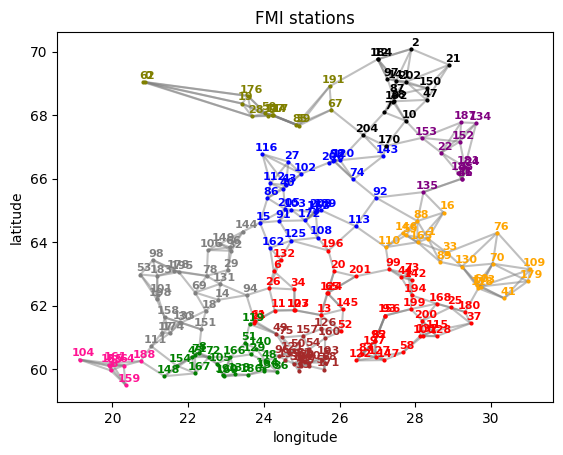

In [46]:
####################TODO####################
# TODO: 1. Construct the Laplacian matrix of G_FMI.
#       2. Compute the eigenvalues and eigenvectors 
#          of the Laplacian matrix.
#       3. Sort both the eigenvalues and the eigenvectors
#          in ascending order.
#       4. Use the first k eigenvectors as
#          a representation vector.
#       5. Cluster the nodes of G_FMI using the Python class sklearn.cluster.KMean.
#       6. Store the cluster labels in the nodes' attribute 'cluster'.

# raise NotImplementedError

# Step 1: Construct the Laplacian matrix
L = nx.laplacian_matrix(G_FMI).astype(float)  # Ensure the Laplacian matrix is in a suitable data type for eigendecomposition

# Step 2: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(L.toarray())

# Step 3: Sort eigenvalues and eigenvectors
# Note: np.linalg.eigh already returns the eigenvalues in ascending order, so this step may be redundant.
idx = eigenvalues.argsort()  # Get the indices that would sort the eigenvalues
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Step 4: Use the first k eigenvectors as a representation vector
# Assuming 'k' is defined; if not, you must define it based on your clustering needs
k = 10  # Example, adjust based on your specific clustering scenario
representation_vectors = eigenvectors[:, 1:k+1]  # Skipping the first eigenvector (corresponding to eigenvalue 0)

# Step 5: Cluster the nodes using KMeans
kmeans = KMeans(n_clusters=k, random_state=seed)
clusters = kmeans.fit_predict(representation_vectors)

# Step 6: Store the cluster labels in the nodes' attribute 'cluster'
for i, cluster_label in enumerate(clusters):
    G_FMI.nodes[i]['cluster'] = cluster_label

# Plot the clustered graph.
plotFMI(G_FMI)

In [47]:
####################TODO####################
# TODO: 1. Compute the average temperature for each cluster.
#       2. Calculate the average (over all nodes) squared 
#          error loss (see the Lecture Notes 6.7).
# NOTE: You can copy your implementation from the cell above.

# raise NotImplementedError
# avg_error = 

# Step 1: Compute the average temperature for each cluster
cluster_temperatures = {cluster: [] for cluster in range(k)}  # k is the number of clusters
for i in G_FMI.nodes:
    cluster = G_FMI.nodes[i]['cluster']
    temperatures = G_FMI.nodes[i]['y']  # y contains the temperatures for the node
    avg_temp = np.mean(temperatures)
    cluster_temperatures[cluster].append(avg_temp)

cluster_average_temps = {cluster: np.mean(temps) for cluster, temps in cluster_temperatures.items()}

# Step 2: Calculate the average squared error loss
squared_errors = []
for i in G_FMI.nodes:
    cluster = G_FMI.nodes[i]['cluster']
    temperatures = G_FMI.nodes[i]['y']
    cluster_avg_temp = cluster_average_temps[cluster]
    # Compute squared error for each temperature of the node
    errors = [(temp - cluster_avg_temp) ** 2 for temp in temperatures]
    squared_errors.extend(errors)

avg_error = np.mean(squared_errors)

# Print the average error.
print(f"The average squared loss over all datapoints is {avg_error}")

The average squared loss over all datapoints is 36.539662249802106
